In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import yaml
import random
from pathlib import Path

# Set up paths
dataset_path = "/home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset"
train_images_path = os.path.join(dataset_path, "images/train")
train_labels_path = os.path.join(dataset_path, "labels/train")
dataset_yaml_path = os.path.join(dataset_path, "dataset.yaml")

# Load dataset configuration
with open(dataset_yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)

class_names = dataset_config['names']
print(f"Dataset classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Dataset classes: {0: 'wood_block', 1: 'cracker_box', 2: 'juice', 3: 'mug', 4: 'cola_can', 5: 'tissue', 6: 'master_chef_can'}
Number of classes: 7


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def yolo_to_bbox(yolo_coords, img_width, img_height):
    """
    Convert YOLO format coordinates to bounding box coordinates
    YOLO format: [class_id, x_center, y_center, width, height] (normalized)
    Returns: [x_min, y_min, x_max, y_max] (absolute coordinates)
    """
    class_id, x_center, y_center, width, height = yolo_coords
    
    # Convert normalized coordinates to absolute coordinates
    x_center_abs = x_center * img_width
    y_center_abs = y_center * img_height
    width_abs = width * img_width
    height_abs = height * img_height
    
    # Calculate bounding box corners
    x_min = int(x_center_abs - width_abs / 2)
    y_min = int(y_center_abs - height_abs / 2)
    x_max = int(x_center_abs + width_abs / 2)
    y_max = int(y_center_abs + height_abs / 2)
    
    return [x_min, y_min, x_max, y_max], int(class_id)

def load_annotations(label_file):
    """Load YOLO format annotations from a text file"""
    annotations = []
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    annotations.append([class_id, x_center, y_center, width, height])
    return annotations

def visualize_sample(image_path, label_path, class_names, ax=None):
    """Visualize a single training sample with bounding boxes"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load annotations
    annotations = load_annotations(label_path)
    
    # Create plot if axis not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Display image
    ax.imshow(image)
    ax.set_title(f"Training Sample: {os.path.basename(image_path)}")
    
    # Define colors for different classes
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray']
    
    # Draw bounding boxes
    for annotation in annotations:
        bbox, class_id = yolo_to_bbox(annotation, img_width, img_height)
        x_min, y_min, x_max, y_max = bbox
        
        # Get class name and color
        class_name = class_names.get(class_id, f'class_{class_id}')
        color = colors[class_id % len(colors)]
        
        # Draw rectangle
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(x_min, y_min - 5, f'{class_name} ({class_id})', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                fontsize=8, color='white', weight='bold')
    
    ax.axis('off')
    
    # Print annotation info
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Image size: {img_width}x{img_height}")
    print(f"Number of objects: {len(annotations)}")
    for i, annotation in enumerate(annotations):
        class_id = int(annotation[0])
        class_name = class_names.get(class_id, f'class_{class_id}')
        print(f"  Object {i+1}: {class_name} (class_id: {class_id})")

def visualize_training_samples(num_samples=6):
    """Visualize multiple training samples in a grid"""
    # Get list of training images
    image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    
    # Randomly select samples
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create subplot grid
    cols = 3
    rows = (len(selected_files) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, image_file in enumerate(selected_files):
        row = i // cols
        col = i % cols
        
        image_path = os.path.join(train_images_path, image_file)
        label_path = os.path.join(train_labels_path, image_file.replace('.jpg', '.txt'))
        
        ax = axes[row, col] if rows > 1 else axes[col]
        visualize_sample(image_path, label_path, class_names, ax)
        print("-" * 50)
    
    # Hide empty subplots
    for i in range(len(selected_files), rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to analyze dataset statistics
def analyze_dataset():
    """Analyze the dataset and show statistics"""
    print("=" * 60)
    print("DATASET ANALYSIS")
    print("=" * 60)
    
    # Count images and labels
    train_images = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    train_labels = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')]
    val_images = [f for f in os.listdir(os.path.join(dataset_path, "images/val")) if f.endswith('.jpg')]
    val_labels = [f for f in os.listdir(os.path.join(dataset_path, "labels/val")) if f.endswith('.txt')]
    
    print(f"Training images: {len(train_images)}")
    print(f"Training labels: {len(train_labels)}")
    print(f"Validation images: {len(val_images)}")
    print(f"Validation labels: {len(val_labels)}")
    
    # Count objects per class
    class_counts = {class_id: 0 for class_id in class_names.keys()}
    total_objects = 0
    
    for label_file in train_labels:
        label_path = os.path.join(train_labels_path, label_file)
        annotations = load_annotations(label_path)
        total_objects += len(annotations)
        
        for annotation in annotations:
            class_id = int(annotation[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
    
    print(f"\nTotal training objects: {total_objects}")
    print("\nClass distribution:")
    for class_id, count in class_counts.items():
        class_name = class_names[class_id]
        percentage = (count / total_objects) * 100 if total_objects > 0 else 0
        print(f"  {class_name} (ID: {class_id}): {count} objects ({percentage:.1f}%)")
    
    return class_counts

In [3]:
# Run dataset analysis
analyze_dataset()

DATASET ANALYSIS
Training images: 84
Training labels: 84
Validation images: 22
Validation labels: 22

Total training objects: 1117

Class distribution:
  wood_block (ID: 0): 181 objects (16.2%)
  cracker_box (ID: 1): 146 objects (13.1%)
  juice (ID: 2): 192 objects (17.2%)
  mug (ID: 3): 152 objects (13.6%)
  cola_can (ID: 4): 159 objects (14.2%)
  tissue (ID: 5): 152 objects (13.6%)
  master_chef_can (ID: 6): 135 objects (12.1%)


{0: 181, 1: 146, 2: 192, 3: 152, 4: 159, 5: 152, 6: 135}


TRAINING SAMPLES VISUALIZATION
Image: 0101.jpg
Image size: 1280x720
Number of objects: 12
  Object 1: cola_can (class_id: 4)
  Object 2: cola_can (class_id: 4)
  Object 3: master_chef_can (class_id: 6)
  Object 4: master_chef_can (class_id: 6)
  Object 5: tissue (class_id: 5)
  Object 6: wood_block (class_id: 0)
  Object 7: wood_block (class_id: 0)
  Object 8: mug (class_id: 3)
  Object 9: juice (class_id: 2)
  Object 10: cracker_box (class_id: 1)
  Object 11: tissue (class_id: 5)
  Object 12: wood_block (class_id: 0)
--------------------------------------------------
Image: 0083.jpg
Image size: 1280x720
Number of objects: 13
  Object 1: mug (class_id: 3)
  Object 2: tissue (class_id: 5)
  Object 3: master_chef_can (class_id: 6)
  Object 4: master_chef_can (class_id: 6)
  Object 5: wood_block (class_id: 0)
  Object 6: juice (class_id: 2)
  Object 7: cola_can (class_id: 4)
  Object 8: wood_block (class_id: 0)
  Object 9: tissue (class_id: 5)
  Object 10: tissue (class_id: 5)
  Object 1

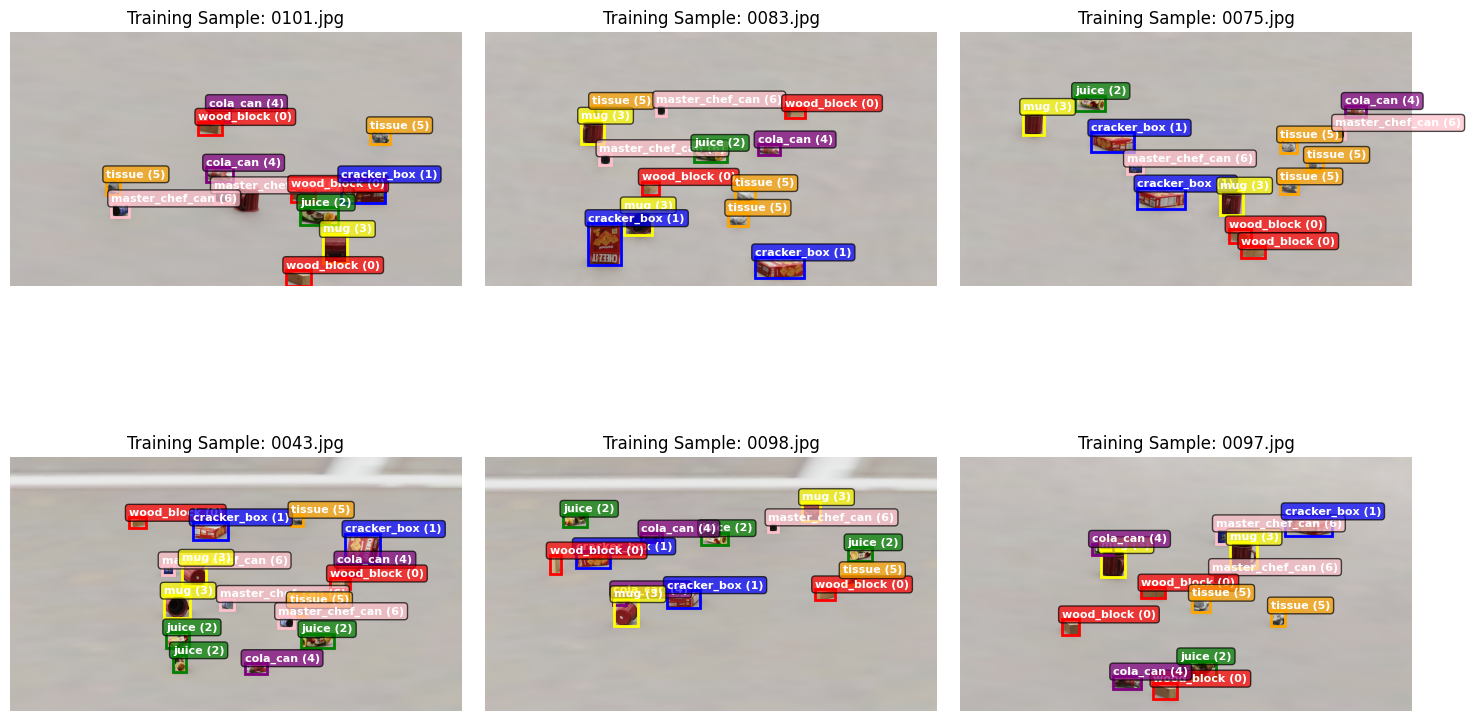

In [4]:
# Visualize 6 random training samples with bounding boxes
print("\n" + "=" * 60)
print("TRAINING SAMPLES VISUALIZATION")
print("=" * 60)
visualize_training_samples(num_samples=6)


DETAILED SINGLE SAMPLE VISUALIZATION
Image: 0001.jpg
Image size: 1280x720
Number of objects: 17
  Object 1: cracker_box (class_id: 1)
  Object 2: juice (class_id: 2)
  Object 3: cola_can (class_id: 4)
  Object 4: tissue (class_id: 5)
  Object 5: wood_block (class_id: 0)
  Object 6: wood_block (class_id: 0)
  Object 7: tissue (class_id: 5)
  Object 8: master_chef_can (class_id: 6)
  Object 9: juice (class_id: 2)
  Object 10: juice (class_id: 2)
  Object 11: master_chef_can (class_id: 6)
  Object 12: master_chef_can (class_id: 6)
  Object 13: cola_can (class_id: 4)
  Object 14: cola_can (class_id: 4)
  Object 15: wood_block (class_id: 0)
  Object 16: mug (class_id: 3)
  Object 17: tissue (class_id: 5)


<Figure size 1200x800 with 0 Axes>

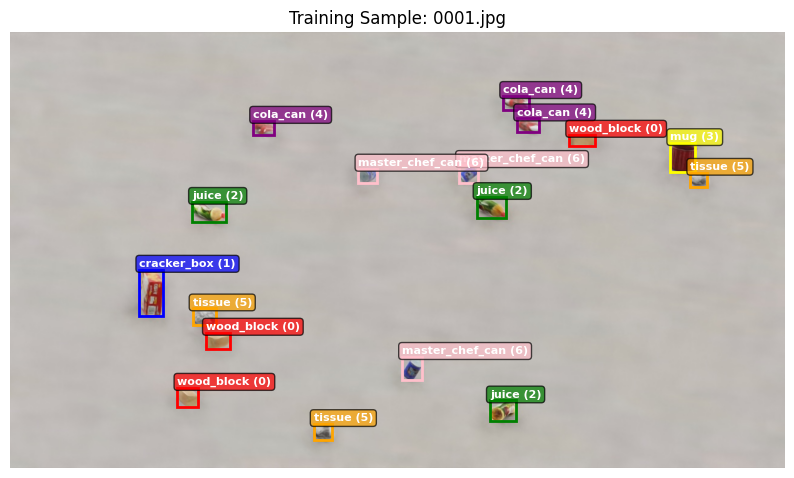

In [5]:
# Visualize a specific training sample in detail
print("\n" + "=" * 60)
print("DETAILED SINGLE SAMPLE VISUALIZATION")
print("=" * 60)

# Choose a specific image for detailed view
sample_image = "0001.jpg"
sample_image_path = os.path.join(train_images_path, sample_image)
sample_label_path = os.path.join(train_labels_path, sample_image.replace('.jpg', '.txt'))

if os.path.exists(sample_image_path) and os.path.exists(sample_label_path):
    plt.figure(figsize=(12, 8))
    visualize_sample(sample_image_path, sample_label_path, class_names)
    plt.show()
else:
    print(f"Sample image {sample_image} not found. Using first available image.")
    # Use first available image
    available_images = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    if available_images:
        sample_image = available_images[0]
        sample_image_path = os.path.join(train_images_path, sample_image)
        sample_label_path = os.path.join(train_labels_path, sample_image.replace('.jpg', '.txt'))
        plt.figure(figsize=(12, 8))
        visualize_sample(sample_image_path, sample_label_path, class_names)
        plt.show()


CLASS DISTRIBUTION VISUALIZATION


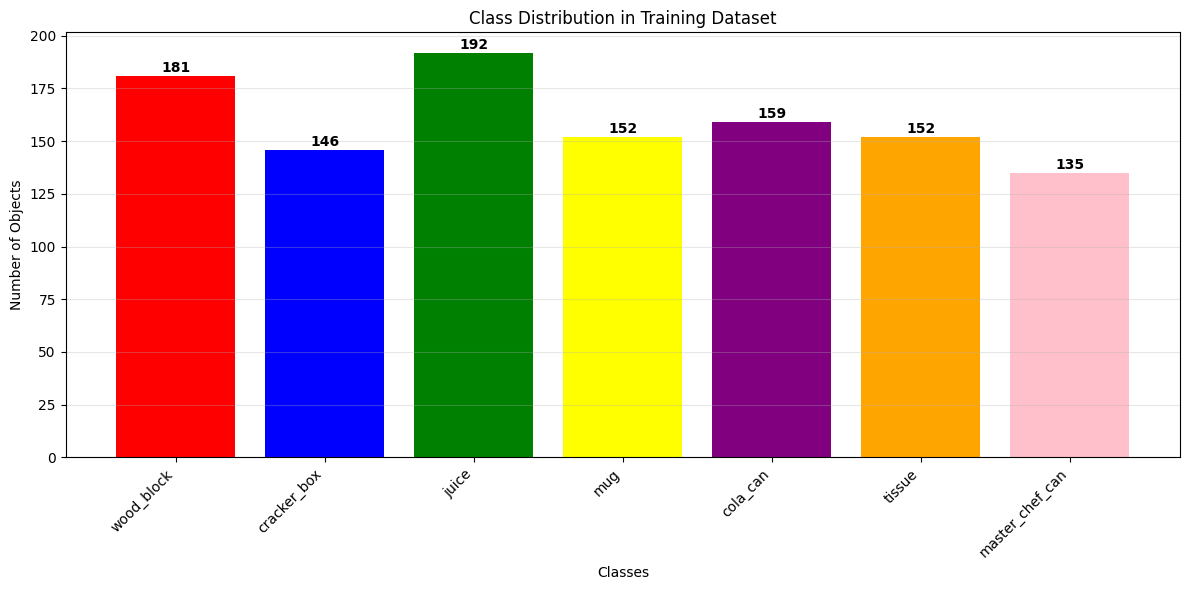

In [6]:
# Visualize class distribution
def plot_class_distribution():
    """Plot class distribution as bar chart"""
    # Count objects per class
    class_counts = {class_id: 0 for class_id in class_names.keys()}
    
    for label_file in os.listdir(train_labels_path):
        if label_file.endswith('.txt'):
            label_path = os.path.join(train_labels_path, label_file)
            annotations = load_annotations(label_path)
            
            for annotation in annotations:
                class_id = int(annotation[0])
                if class_id in class_counts:
                    class_counts[class_id] += 1
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    class_ids = list(class_counts.keys())
    counts = list(class_counts.values())
    class_labels = [class_names[cid] for cid in class_ids]
    
    bars = ax.bar(class_labels, counts, color=['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink'])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Objects')
    ax.set_title('Class Distribution in Training Dataset')
    ax.grid(axis='y', alpha=0.3)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return class_counts

print("\n" + "=" * 60)
print("CLASS DISTRIBUTION VISUALIZATION")
print("=" * 60)
class_distribution = plot_class_distribution()

In [7]:
import torch

torch.cuda.is_available()

True

IMAGE AUGMENTATION PREVIEW
✓ Albumentations library is available
📸 Previewing augmentations on: 0078.jpg


/tmp/ipykernel_3260736/1046386458.py:13: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
/home/kwdahun/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_3260736/1046386458.py:14: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_3260736/1046386458.py:41: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
/tmp/ipykernel_3260736/1046386458.py:44: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


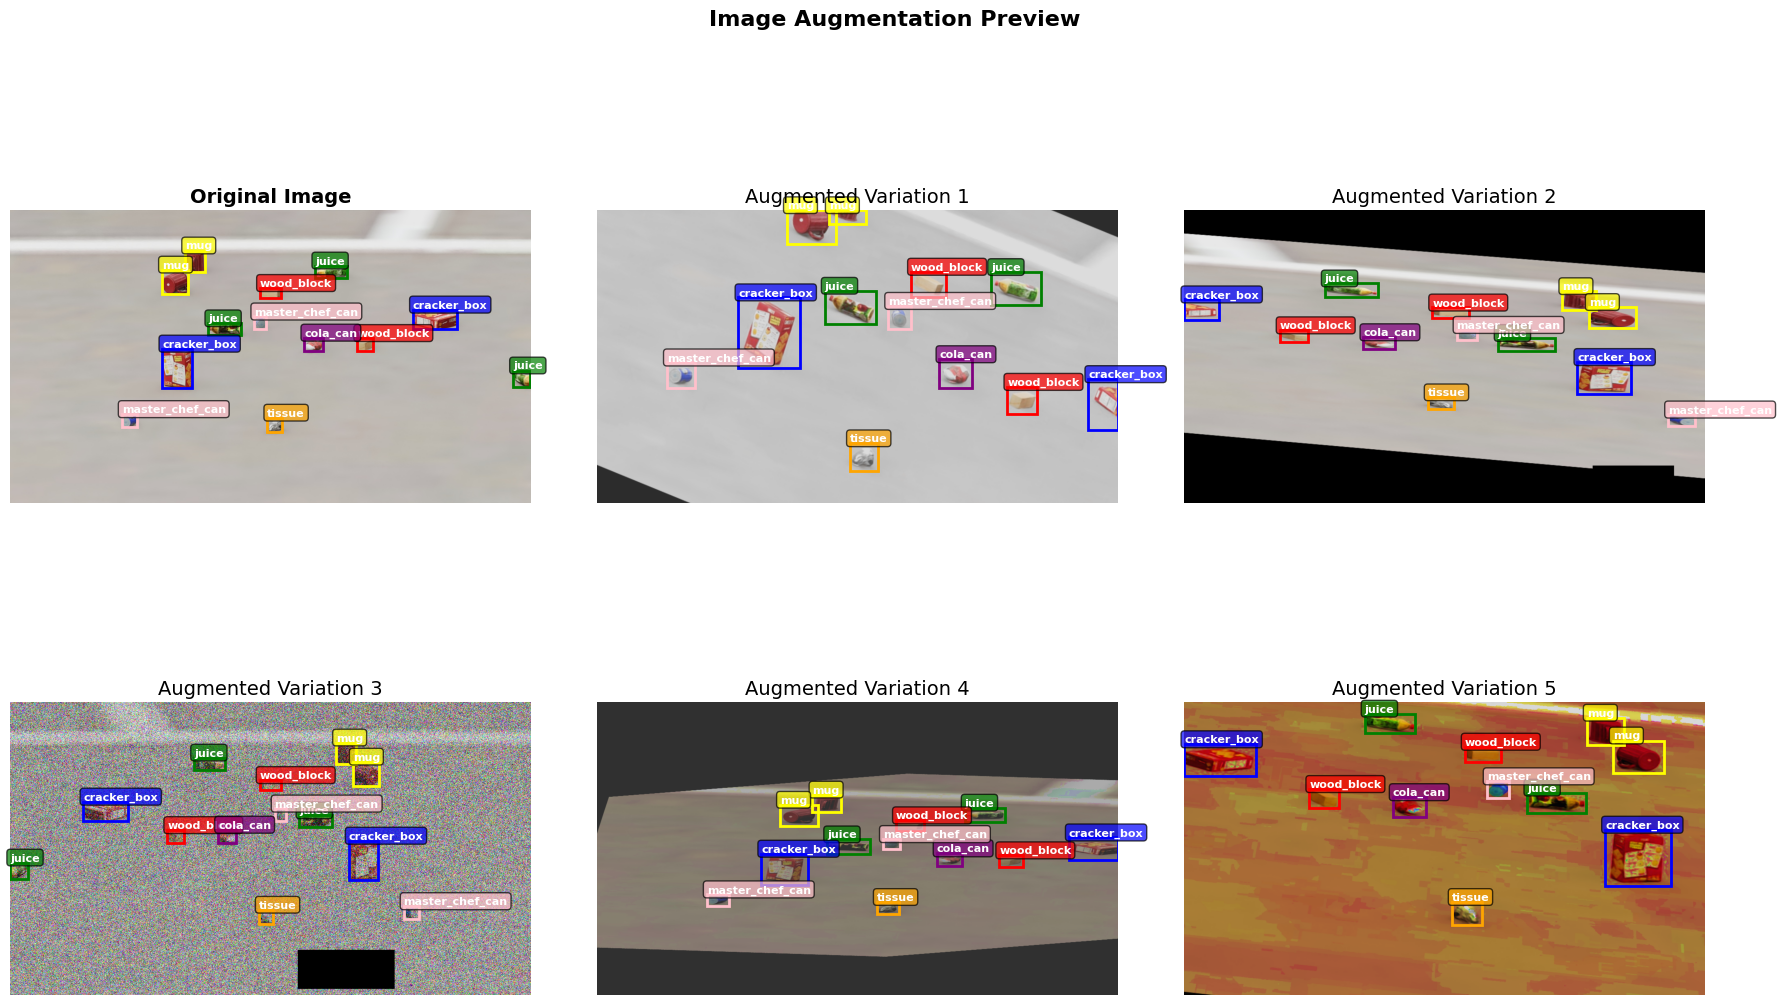

In [8]:
# Preview Image Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

def create_augmentation_pipeline():
    """Create an augmentation pipeline similar to YOLO's augmentations"""
    return A.Compose([
        # Geometric transformations
        A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ShiftScaleRotate(
            shift_limit=0.1, 
            scale_limit=0.5, 
            rotate_limit=15, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.7
        ),
        A.Perspective(scale=(0.05, 0.1), p=0.3),
        A.HorizontalFlip(p=0.5),
        
        # Color transformations
        A.HueSaturationValue(
            hue_shift_limit=int(0.015 * 180),
            sat_shift_limit=int(0.7 * 255),
            val_shift_limit=int(0.4 * 255),
            p=0.7
        ),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        
        # Noise and blur
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.MotionBlur(blur_limit=3, p=0.3),
        ], p=0.3),
        
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        
        # Random erasing
        A.CoarseDropout(
            max_holes=8, 
            max_height=32, 
            max_width=32, 
            min_holes=1, 
            min_height=8, 
            min_width=8, 
            fill_value=0, 
            p=0.4
        ),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def visualize_augmentations(image_path, label_path, num_variations=6):
    """Visualize original image and augmented variations"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load YOLO annotations
    annotations = load_annotations(label_path)
    
    # Convert YOLO format to albumentations format
    bboxes = []
    class_labels = []
    
    img_height, img_width = image.shape[:2]
    for annotation in annotations:
        class_id, x_center, y_center, width, height = annotation
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(class_id)
    
    # Create augmentation pipeline
    transform = create_augmentation_pipeline()
    
    # Create subplot grid
    cols = 3
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
    
    # Show original image first
    ax = axes[0, 0]
    ax.imshow(image)
    ax.set_title("Original Image", fontsize=14, fontweight='bold')
    
    # Draw original bounding boxes
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan']
    for bbox, class_id in zip(bboxes, class_labels):
        x_center, y_center, width, height = bbox
        # Convert to pixel coordinates for visualization
        x_center_abs = x_center * img_width
        y_center_abs = y_center * img_height
        width_abs = width * img_width
        height_abs = height * img_height
        
        x_min = int(x_center_abs - width_abs / 2)
        y_min = int(y_center_abs - height_abs / 2)
        x_max = int(x_center_abs + width_abs / 2)
        y_max = int(y_center_abs + height_abs / 2)
        
        color = colors[int(class_id) % len(colors)]
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                           linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        class_name = class_names.get(int(class_id), f'class_{int(class_id)}')
        ax.text(x_min, y_min - 5, f'{class_name}', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
               fontsize=8, color='white', weight='bold')
    
    ax.axis('off')
    
    # Generate augmented variations
    for i in range(num_variations - 1):
        row = (i + 1) // cols
        col = (i + 1) % cols
        ax = axes[row, col]
        
        try:
            # Apply augmentation
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']
            
            # Display augmented image
            ax.imshow(aug_image)
            ax.set_title(f"Augmented Variation {i+1}", fontsize=14)
            
            # Draw augmented bounding boxes
            for bbox, class_id in zip(aug_bboxes, aug_labels):
                x_center, y_center, width, height = bbox
                # Convert to pixel coordinates for visualization
                x_center_abs = x_center * img_width
                y_center_abs = y_center * img_height
                width_abs = width * img_width
                height_abs = height * img_height
                
                x_min = int(x_center_abs - width_abs / 2)
                y_min = int(y_center_abs - height_abs / 2)
                x_max = int(x_center_abs + width_abs / 2)
                y_max = int(y_center_abs + height_abs / 2)
                
                color = colors[int(class_id) % len(colors)]
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                class_name = class_names.get(int(class_id), f'class_{int(class_id)}')
                ax.text(x_min, y_min - 5, f'{class_name}', 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                       fontsize=8, color='white', weight='bold')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Augmentation failed:\n{str(e)}', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.5", facecolor='red', alpha=0.7))
        
        ax.axis('off')
    
    plt.suptitle("Image Augmentation Preview", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def preview_augmentations():
    """Preview augmentations on a sample image"""
    print("=" * 60)
    print("IMAGE AUGMENTATION PREVIEW")
    print("=" * 60)
    
    # Check if albumentations is installed
    try:
        import albumentations
        print("✓ Albumentations library is available")
    except ImportError:
        print("⚠️ Installing albumentations for augmentation preview...")
        import subprocess
        subprocess.check_call(["pip", "install", "albumentations"])
        import albumentations as A
    
    # Select a random training image
    train_images = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    if train_images:
        sample_image = random.choice(train_images)
        sample_image_path = os.path.join(train_images_path, sample_image)
        sample_label_path = os.path.join(train_labels_path, sample_image.replace('.jpg', '.txt'))
        
        print(f"📸 Previewing augmentations on: {sample_image}")
        
        if os.path.exists(sample_label_path):
            visualize_augmentations(sample_image_path, sample_label_path)
        else:
            print(f"⚠️ Label file not found for {sample_image}")
    else:
        print("❌ No training images found")

# Run augmentation preview
preview_augmentations()

# 🎨 Image Augmentation Configuration Guide

Image augmentation is a powerful technique to improve model robustness and generalization by artificially expanding your training dataset. Below are the augmentation parameters added to the YOLO training:

## 🔄 Geometric Augmentations
- **`degrees=15.0`**: Random rotation (±15 degrees) - helps model handle rotated objects
- **`translate=0.1`**: Random translation (±10% of image size) - improves position invariance
- **`scale=0.5`**: Random scaling (0.5 to 1.5x) - handles objects at different scales
- **`shear=10.0`**: Random shear (±10 degrees) - simulates perspective changes
- **`perspective=0.0003`**: Random perspective transformation - mimics camera angle changes
- **`fliplr=0.5`**: Horizontal flip probability (50%) - doubles effective dataset size
- **`flipud=0.0`**: Vertical flip probability (disabled) - usually not useful for real-world objects

## 🎨 Color Augmentations
- **`hsv_h=0.015`**: HSV-Hue augmentation - handles different lighting conditions
- **`hsv_s=0.7`**: HSV-Saturation augmentation - compensates for color variations
- **`hsv_v=0.4`**: HSV-Value augmentation - handles brightness changes

## 🧩 Advanced Augmentations
- **`mosaic=1.0`**: Mosaic augmentation (100%) - combines 4 images into one training sample
- **`mixup=0.1`**: MixUp augmentation (10%) - blends two images and their labels
- **`copy_paste=0.1`**: Copy-paste augmentation (10%) - copies objects between images
- **`erasing=0.4`**: Random erasing (40%) - randomly masks parts of the image

**Note**: Some augmentation parameters like `blur`, `noise`, and `auto_augment` are not supported in the current YOLO version and have been removed.

## ⚙️ Customization Tips

### For Small Datasets (< 1000 images):
- Increase augmentation strength: `degrees=20, scale=0.7, hsv_s=0.9`
- Higher mosaic probability: `mosaic=1.0`
- More aggressive erasing: `erasing=0.6`

### For Large Datasets (> 10000 images):
- Reduce augmentation strength: `degrees=10, scale=0.3, hsv_s=0.5`
- Lower mixup: `mixup=0.05`
- Conservative erasing: `erasing=0.2`

### For Specific Object Types:
- **Symmetrical objects**: Enable `flipud=0.5`
- **Fixed orientation objects**: Reduce `degrees=5`
- **Color-sensitive objects**: Reduce `hsv_h=0.005, hsv_s=0.3`

You can modify these parameters in the training cell above based on your specific dataset and requirements!

In [9]:
# Check Valid YOLO Augmentation Parameters
from ultralytics import YOLO

def show_valid_yolo_parameters():
    """Display the valid YOLO training parameters"""
    print("=" * 60)
    print("VALID YOLO AUGMENTATION PARAMETERS")
    print("=" * 60)
    
    # Load a YOLO model to check available parameters
    model = YOLO("yolo11n.pt")
    
    print("✅ Valid augmentation parameters for YOLO training:")
    print("\n🔄 Geometric Augmentations:")
    print("  - degrees: Random rotation (±degrees)")
    print("  - translate: Random translation (fraction of image size)")
    print("  - scale: Random scaling factor")
    print("  - shear: Random shear (±degrees)")
    print("  - perspective: Random perspective transformation")
    print("  - flipud: Vertical flip probability")
    print("  - fliplr: Horizontal flip probability")
    
    print("\n🎨 Color Augmentations:")
    print("  - hsv_h: HSV-Hue augmentation (fraction)")
    print("  - hsv_s: HSV-Saturation augmentation (fraction)")
    print("  - hsv_v: HSV-Value augmentation (fraction)")
    
    print("\n🧩 Advanced Augmentations:")
    print("  - mosaic: Mosaic augmentation probability")
    print("  - mixup: MixUp augmentation probability")
    print("  - copy_paste: Copy-paste augmentation probability")
    print("  - erasing: Random erasing probability")
    
    print("\n❌ NOT SUPPORTED in current YOLO version:")
    print("  - blur: Use albumentations for blur effects")
    print("  - noise: Use albumentations for noise")
    print("  - auto_augment: Not available in this version")
    
    print("\n💡 TIP: For additional augmentations like blur and noise,")
    print("   consider preprocessing your dataset with albumentations!")

# Show valid parameters
show_valid_yolo_parameters()

VALID YOLO AUGMENTATION PARAMETERS
✅ Valid augmentation parameters for YOLO training:

🔄 Geometric Augmentations:
  - degrees: Random rotation (±degrees)
  - translate: Random translation (fraction of image size)
  - scale: Random scaling factor
  - shear: Random shear (±degrees)
  - perspective: Random perspective transformation
  - flipud: Vertical flip probability
  - fliplr: Horizontal flip probability

🎨 Color Augmentations:
  - hsv_h: HSV-Hue augmentation (fraction)
  - hsv_s: HSV-Saturation augmentation (fraction)
  - hsv_v: HSV-Value augmentation (fraction)

🧩 Advanced Augmentations:
  - mosaic: Mosaic augmentation probability
  - mixup: MixUp augmentation probability
  - copy_paste: Copy-paste augmentation probability
  - erasing: Random erasing probability

❌ NOT SUPPORTED in current YOLO version:
  - blur: Use albumentations for blur effects
  - noise: Use albumentations for noise
  - auto_augment: Not available in this version

💡 TIP: For additional augmentations like blur 

In [10]:
# Import YOLO for fine-tuning
from ultralytics import YOLO
import time

print("=" * 60)
print("YOLO MODEL FINE-TUNING")
print("=" * 60)

# Step 1: Load pre-trained model
print("📦 Loading pre-trained YOLO model...")
model_path = "runs/detect/metasejong_objects/weights/best.pt"
model = YOLO(model_path)
print(f"✓ Model loaded from: {model_path}")

# Step 2: Verify dataset configuration
print(f"📊 Dataset configuration:")
print(f"  - Dataset path: {dataset_yaml_path}")
print(f"  - Number of classes: {len(class_names)}")
print(f"  - Classes: {list(class_names.values())}")

# Step 3: Start fine-tuning
print("\n🚀 Starting fine-tuning process...")
start_time = time.time()

try:
    results = model.train(
        data=dataset_yaml_path,  # Use the dataset.yaml path from our setup
        epochs=50,               # Training epochs
        imgsz=640,              # Image size
        batch=8,                # Batch size
        lr0=0.001,              # Initial learning rate
        weight_decay=0.0005,    # Weight decay for regularization
        warmup_epochs=3,        # Warmup epochs
        patience=15,            # Early stopping patience
        save_period=10,         # Save checkpoint every 10 epochs
        name="metasejong_objects_augmented",  # Project name
        exist_ok=True,          # Overwrite existing project
        pretrained=True,        # Use pretrained weights
        optimizer='AdamW',      # Optimizer
        cos_lr=True,            # Cosine learning rate scheduler
        freeze=10,              # Freeze first 10 layers initially
        verbose=True,           # Verbose output
        plots=True,             # Generate training plots
        val=True,               # Validate during training
        save=True,              # Save final model
        cache=False,            # Don't cache images (saves memory)
        device='cuda',          # Auto-select device (GPU if available)
        
        # ===== IMAGE AUGMENTATION PARAMETERS =====
        # Geometric augmentations
        degrees=15.0,           # Random rotation (±15 degrees)
        translate=0.1,          # Random translation (±10% of image size)
        scale=0.5,              # Random scaling (0.5 to 1.5x)
        shear=10.0,            # Random shear (±10 degrees)
        perspective=0.0003,     # Random perspective transformation
        flipud=0.0,            # Vertical flip probability (0.0 = disabled)
        fliplr=0.5,            # Horizontal flip probability (50%)
        
        # Color augmentations
        hsv_h=0.015,           # HSV-Hue augmentation (fraction)
        hsv_s=0.7,             # HSV-Saturation augmentation (fraction)
        hsv_v=0.4,             # HSV-Value augmentation (fraction)
        
        # Advanced augmentations
        mosaic=1.0,            # Mosaic augmentation probability (100%)
        mixup=0.1,             # MixUp augmentation probability (10%)
        copy_paste=0.1,        # Copy-paste augmentation probability (10%)
        
        # Augmentation settings
        erasing=0.4,           # Random erasing probability (40%)
    )
    
    training_time = time.time() - start_time
    print(f"\n✅ Training completed successfully!")
    print(f"⏱️  Total training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
    
    # Display training results
    print(f"\n📈 Training Results:")
    print(f"  - Best mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A')}")
    print(f"  - Best mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A')}")
    print(f"  - Final loss: {results.results_dict.get('train/box_loss', 'N/A')}")
    
    # Model save location
    print(f"\n💾 Model saved to: {results.save_dir}")
    print(f"  - Best weights: {results.save_dir}/weights/best.pt")
    print(f"  - Last weights: {results.save_dir}/weights/last.pt")
    
except Exception as e:
    print(f"❌ Training failed with error: {str(e)}")
    print("Please check your dataset configuration and try again.")

YOLO MODEL FINE-TUNING
📦 Loading pre-trained YOLO model...
✓ Model loaded from: runs/detect/metasejong_objects/weights/best.pt
📊 Dataset configuration:
  - Dataset path: /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/dataset.yaml
  - Number of classes: 7
  - Classes: ['wood_block', 'cracker_box', 'juice', 'mug', 'cola_can', 'tissue', 'master_chef_can']

🚀 Starting fine-tuning process...
Ultralytics 8.3.161 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
Ultralytics 8.3.161 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/dataset.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=Fals

YOLO11n summary: 181 layers, 2,591,205 parameters, 2,591,189 gradients, 6.4 GFLOPs


Transferred 499/499 items from pretrained weights
Transferred 499/499 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.w

train: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/train.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1857.4±1206.1 MB/s, size: 82.1 KB)


val: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]



Plotting labels to runs/detect/metasejong_objects_augmented/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/metasejong_objects_augmented
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/metasejong_objects_augmented
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.838G      1.365     0.6978      1.069         82        640: 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         22        278      0.918      0.892      0.975      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.934G      1.091     0.6764     0.9424        113        640: 100%|██████████| 11/11 [00:00<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.87it/s]

                   all         22        278      0.868      0.926      0.977      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.943G      1.095     0.6834     0.9435         78        640: 100%|██████████| 11/11 [00:00<00:00, 15.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.75it/s]


                   all         22        278      0.884      0.944      0.976      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.05G      1.095       0.72     0.9546         44        640: 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]
       4/50      1.05G      1.095       0.72     0.9546         44        640: 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.46it/s]

                   all         22        278      0.943      0.956      0.977      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.05G      1.086     0.6924     0.9295        122        640: 100%|██████████| 11/11 [00:00<00:00, 16.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 21.68it/s]

                   all         22        278      0.933      0.939       0.97      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.05G      1.075     0.6876     0.9351        142        640: 100%|██████████| 11/11 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.89it/s]

                   all         22        278      0.913      0.956      0.974      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.05G      1.105     0.6775     0.9099        123        640: 100%|██████████| 11/11 [00:00<00:00, 12.75it/s]
       7/50      1.05G      1.105     0.6775     0.9099        123        640: 100%|██████████| 11/11 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.23it/s]

                   all         22        278       0.97      0.944      0.977      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.06G      1.057     0.6775     0.9362         68        640: 100%|██████████| 11/11 [00:00<00:00, 11.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.36it/s]

                   all         22        278      0.969      0.969      0.978      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.08G      1.095     0.6677     0.9093        108        640: 100%|██████████| 11/11 [00:01<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.32it/s]

                   all         22        278      0.976      0.963      0.978      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.09G      1.071     0.6687     0.9408         81        640: 100%|██████████| 11/11 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]

                   all         22        278      0.984      0.955      0.979        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.1G      1.059     0.6563     0.9392        136        640: 100%|██████████| 11/11 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.97it/s]


                   all         22        278      0.981      0.952      0.979      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       1.1G      1.021     0.6531     0.9161        103        640: 100%|██████████| 11/11 [00:00<00:00, 13.57it/s]
      12/50       1.1G      1.021     0.6531     0.9161        103        640: 100%|██████████| 11/11 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.76it/s]

                   all         22        278      0.981      0.952      0.979      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.12G      1.008     0.6256     0.9047         96        640: 100%|██████████| 11/11 [00:00<00:00, 12.54it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]

                   all         22        278      0.977      0.953      0.979      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.13G       1.01     0.6312     0.9104         87        640: 100%|██████████| 11/11 [00:00<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

                   all         22        278      0.971       0.96      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.13G     0.9805     0.6167     0.9156        152        640: 100%|██████████| 11/11 [00:01<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.12it/s]


                   all         22        278      0.961      0.964      0.977      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.13G     0.9831      0.641     0.9133        100        640: 100%|██████████| 11/11 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.69it/s]

                   all         22        278      0.963      0.966      0.977      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.24G      1.008      0.632     0.9017        108        640: 100%|██████████| 11/11 [00:00<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.43it/s]

                   all         22        278      0.957      0.968       0.98      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.24G      1.056      0.661     0.9091         79        640: 100%|██████████| 11/11 [00:00<00:00, 11.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.57it/s]

                   all         22        278      0.952      0.959      0.979       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.24G      1.036     0.6506      0.921         88        640: 100%|██████████| 11/11 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.48it/s]

                   all         22        278      0.936      0.957      0.978      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.24G     0.9526     0.6347     0.8899         60        640: 100%|██████████| 11/11 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.61it/s]

                   all         22        278      0.923      0.952      0.974       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.24G     0.9598     0.5993     0.8952        102        640: 100%|██████████| 11/11 [00:01<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]

                   all         22        278      0.933      0.957      0.977      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.24G     0.9754     0.6791     0.8903        117        640: 100%|██████████| 11/11 [00:00<00:00, 11.06it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.25it/s]

                   all         22        278      0.959      0.944      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.24G     0.9278     0.5908     0.9018         58        640: 100%|██████████| 11/11 [00:01<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.20it/s]

                   all         22        278      0.975       0.95      0.977      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.24G     0.8647     0.5717     0.8864         81        640: 100%|██████████| 11/11 [00:01<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.09it/s]

                   all         22        278      0.968      0.949      0.976      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.24G     0.8946     0.5966     0.8822         83        640: 100%|██████████| 11/11 [00:01<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.36it/s]

                   all         22        278      0.967      0.946      0.976      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.24G     0.9615     0.6167     0.8919        115        640: 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.28it/s]

                   all         22        278      0.959      0.959      0.976      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.24G     0.9239     0.5872     0.8985        108        640: 100%|██████████| 11/11 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.10it/s]

                   all         22        278      0.964      0.963      0.977       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.24G     0.9254     0.5708      0.874         93        640: 100%|██████████| 11/11 [00:01<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.69it/s]

                   all         22        278      0.969      0.956      0.977      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.24G       0.89     0.5576     0.8794        135        640: 100%|██████████| 11/11 [00:00<00:00, 11.16it/s]
      29/50      1.24G       0.89     0.5576     0.8794        135        640: 100%|██████████| 11/11 [00:00<00:00, 11.16it/s]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.81it/s]

                   all         22        278       0.97      0.958      0.977      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.24G     0.9155     0.6023     0.8844        102        640: 100%|██████████| 11/11 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.83it/s]

                   all         22        278      0.977      0.957      0.977      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.24G     0.8612     0.5422     0.8831         65        640: 100%|██████████| 11/11 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.72it/s]

                   all         22        278      0.972      0.956      0.977      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.24G     0.8717     0.5451     0.8714        114        640: 100%|██████████| 11/11 [00:01<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.12it/s]

                   all         22        278      0.978      0.958      0.976      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.24G     0.8854      0.552     0.8953         62        640: 100%|██████████| 11/11 [00:01<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.27it/s]

                   all         22        278      0.974       0.96      0.976      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.24G     0.8858     0.5455     0.8779        131        640: 100%|██████████| 11/11 [00:01<00:00, 10.78it/s]
      34/50      1.24G     0.8858     0.5455     0.8779        131        640: 100%|██████████| 11/11 [00:01<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.99it/s]

                   all         22        278      0.974      0.963      0.976      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.24G     0.8952     0.5592     0.8896        116        640: 100%|██████████| 11/11 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.63it/s]

                   all         22        278      0.974      0.963      0.976      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.24G     0.8616     0.5513     0.8929         70        640: 100%|██████████| 11/11 [00:00<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.46it/s]

                   all         22        278      0.971      0.961      0.976       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.24G      0.871     0.5145      0.876         89        640: 100%|██████████| 11/11 [00:01<00:00, 10.87it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.80it/s]

                   all         22        278      0.972      0.962      0.976      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.24G     0.8544     0.5484     0.8774        140        640: 100%|██████████| 11/11 [00:00<00:00, 11.77it/s]
      38/50      1.24G     0.8544     0.5484     0.8774        140        640: 100%|██████████| 11/11 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.12it/s]

                   all         22        278      0.972      0.961      0.976      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.24G     0.8713     0.5545     0.8695        145        640: 100%|██████████| 11/11 [00:01<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.19it/s]

                   all         22        278      0.975      0.959      0.977      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.24G     0.8476     0.5223     0.8813         87        640: 100%|██████████| 11/11 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         22        278      0.976       0.96      0.977       0.78


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.24G     0.7739     0.5505     0.8648         54        640: 100%|██████████| 11/11 [00:01<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.19it/s]

                   all         22        278       0.97       0.96      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.24G     0.7818     0.5321     0.8623         47        640: 100%|██████████| 11/11 [00:00<00:00, 11.04it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.11it/s]

                   all         22        278       0.97       0.96      0.977      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.24G     0.7906      0.515     0.8678         58        640: 100%|██████████| 11/11 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.28it/s]

                   all         22        278      0.972      0.959      0.977      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.24G     0.8198      0.558     0.8847         51        640: 100%|██████████| 11/11 [00:00<00:00, 11.46it/s]
      44/50      1.24G     0.8198      0.558     0.8847         51        640: 100%|██████████| 11/11 [00:00<00:00, 11.46it/s]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 22.87it/s]

                   all         22        278      0.966      0.969      0.977      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.24G     0.8426     0.5334     0.8866         47        640: 100%|██████████| 11/11 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]

                   all         22        278      0.966      0.968      0.977      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.24G     0.7499     0.4807     0.8664         58        640: 100%|██████████| 11/11 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.40it/s]

                   all         22        278      0.967      0.968      0.977      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.24G     0.7637     0.5021       0.86         60        640: 100%|██████████| 11/11 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.33it/s]

                   all         22        278      0.969      0.969      0.977      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.24G     0.8079     0.5022     0.8795         54        640: 100%|██████████| 11/11 [00:00<00:00, 13.95it/s]
      48/50      1.24G     0.8079     0.5022     0.8795         54        640: 100%|██████████| 11/11 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.81it/s]

                   all         22        278      0.969      0.969      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.24G     0.7648     0.4902     0.8722         58        640: 100%|██████████| 11/11 [00:00<00:00, 12.44it/s]
      49/50      1.24G     0.7648     0.4902     0.8722         58        640: 100%|██████████| 11/11 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 22.70it/s]

                   all         22        278      0.972      0.964      0.977       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.24G     0.7867     0.4947     0.8712         53        640: 100%|██████████| 11/11 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 21.86it/s]

                   all         22        278      0.972      0.964      0.977      0.792



50 epochs completed in 0.018 hours.
Optimizer stripped from runs/detect/metasejong_objects_augmented/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/metasejong_objects_augmented/weights/best.pt, 5.4MB

Validating runs/detect/metasejong_objects_augmented/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
Optimizer stripped from runs/detect/metasejong_objects_augmented/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/metasejong_objects_augmented/weights/best.pt, 5.4MB

Validating runs/detect/metasejong_objects_augmented/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.69it/s]



                   all         22        278      0.965      0.969      0.977      0.794
            wood_block         22         46      0.968          1      0.984      0.819
           cracker_box         22         37      0.966          1      0.982      0.811
                 juice         20         43      0.976          1      0.995      0.824
                   mug         21         43      0.967      0.977      0.978        0.8
              cola_can         21         41      0.951      0.944       0.98       0.79
                tissue         19         38      0.936      0.895      0.946      0.753
       master_chef_can         20         30      0.993      0.967      0.975      0.763
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/metasejong_objects_augmented
            wood_block         22         46      0.968          1      0.984      0.819
           cracker_box         22         37      0.966    

In [11]:
# Model Evaluation and Validation
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Load the best trained model for evaluation
try:
    # Path to the best model weights (update this path based on your training results)
    best_model_path = "runs/detect/metasejong_objects_augmented/weights/best.pt"
    
    if os.path.exists(best_model_path):
        print(f"📊 Loading best model from: {best_model_path}")
        trained_model = YOLO(best_model_path)
        
        # Validate the model on validation set
        print("\n🔍 Validating model on validation set...")
        val_results = trained_model.val(
            data=dataset_yaml_path,
            imgsz=640,
            batch=8,
            conf=0.25,
            iou=0.5,
            plots=True,
            save_json=True,
            name="validation_results"
        )
        
        # Display validation metrics
        print(f"\n📈 Validation Results:")
        print(f"  - mAP50: {val_results.box.map50:.4f}")
        print(f"  - mAP50-95: {val_results.box.map:.4f}")
        print(f"  - Precision: {val_results.box.mp:.4f}")
        print(f"  - Recall: {val_results.box.mr:.4f}")
        
        # Per-class metrics
        print(f"\n📊 Per-class metrics:")
        for i, class_name in enumerate(class_names.values()):
            if i < len(val_results.box.ap50):
                ap50 = val_results.box.ap50[i]
                print(f"  - {class_name}: mAP50 = {ap50:.4f}")
        
        print(f"\n✅ Model evaluation completed!")
        
    else:
        print(f"❌ Best model not found at: {best_model_path}")
        print("Please make sure training has completed successfully.")
        
except Exception as e:
    print(f"❌ Evaluation failed with error: {str(e)}")
    print("Training might still be in progress or failed.")

MODEL EVALUATION
📊 Loading best model from: runs/detect/metasejong_objects_augmented/weights/best.pt

🔍 Validating model on validation set...
Ultralytics 8.3.161 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2632.3±350.4 MB/s, size: 77.6 KB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2632.3±350.4 MB/s, size: 77.6 KB)


val: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]



                   all         22        278      0.973      0.968      0.981      0.815
            wood_block         22         46      0.969          1      0.984      0.835
           cracker_box         22         37      0.966          1      0.982      0.816
                 juice         20         43          1      0.999      0.995      0.841
                   mug         21         43      0.986      0.977      0.987      0.819
              cola_can         21         41      0.951      0.939       0.98      0.807
                tissue         19         38      0.937      0.895      0.954      0.779
       master_chef_can         20         30          1      0.967      0.983      0.809
Speed: 0.9ms preprocess, 43.4ms inference, 0.0ms loss, 20.5ms postprocess per image
Saving runs/detect/validation_results2/predictions.json...
            wood_block         22         46      0.969          1      0.984      0.835
           cracker_box         22         37      0.966 

TESTING TRAINED MODEL
🧪 Testing trained model...
🧪 Testing model on 4 sample images...🧪 Testing model on 4 sample images...

  ✓ 0067.jpg: 12 objects detected
  ✓ 0067.jpg: 12 objects detected
  ✓ 0049.jpg: 16 objects detected
  ✓ 0096.jpg: 13 objects detected
  ✓ 0085.jpg: 15 objects detected
  ✓ 0049.jpg: 16 objects detected
  ✓ 0096.jpg: 13 objects detected
  ✓ 0085.jpg: 15 objects detected


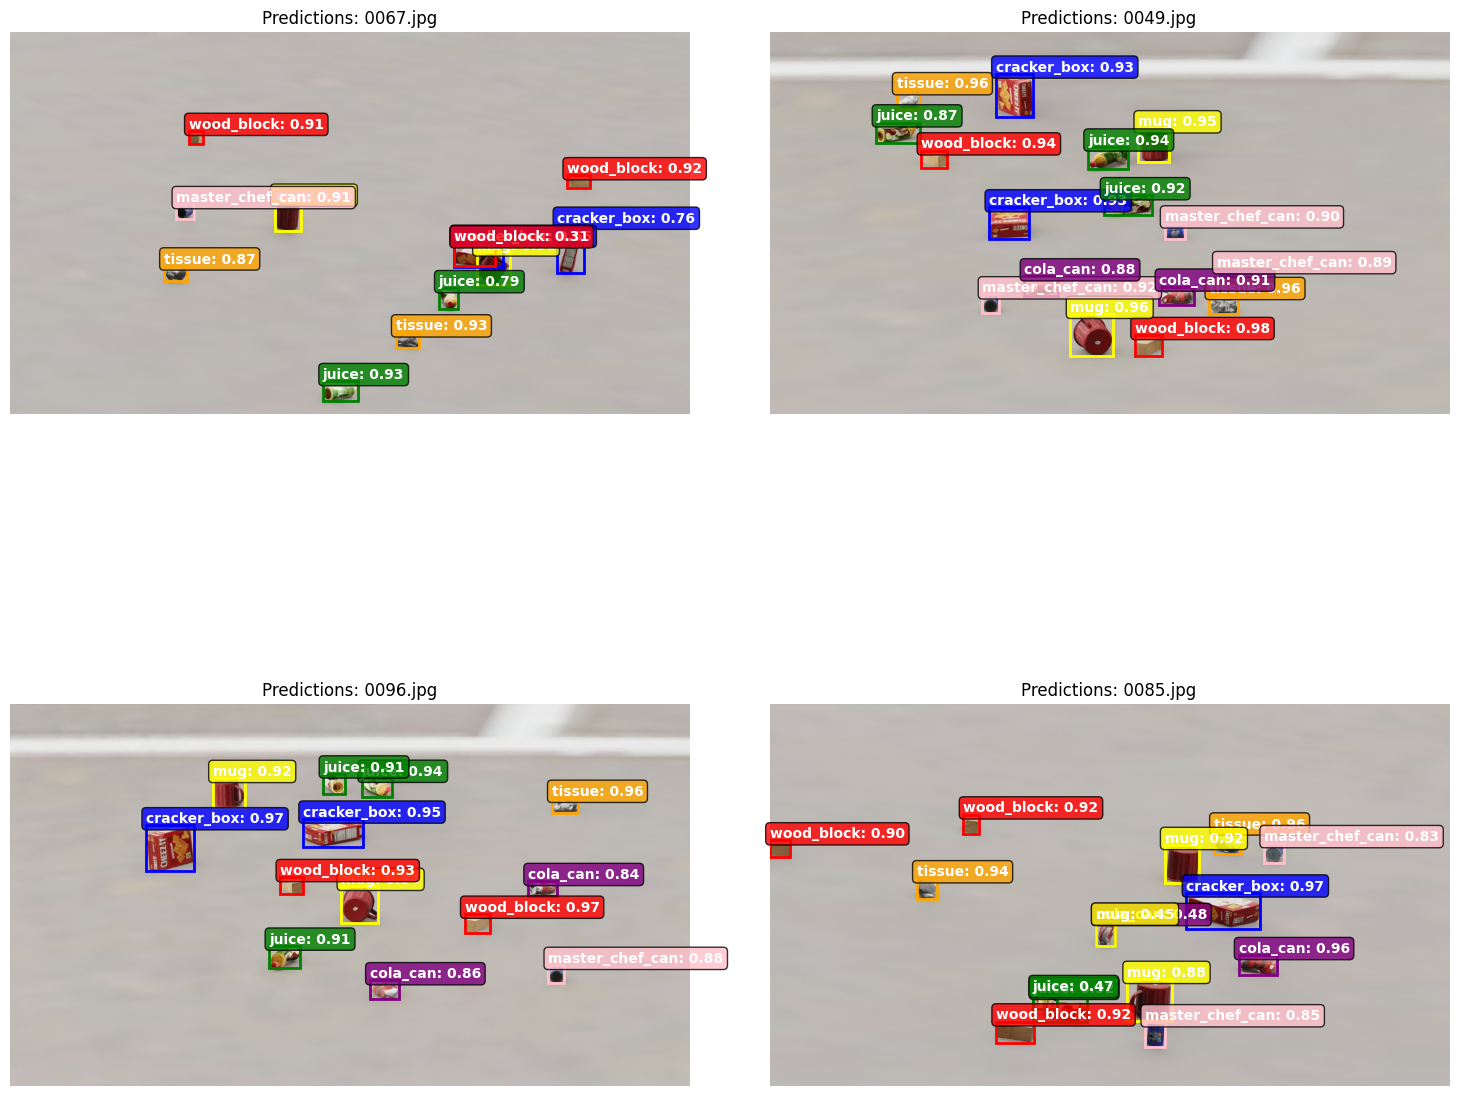

✅ Testing completed on 4 images!


In [12]:
from ultralytics import YOLO

# Test the trained model on sample images
print("=" * 60)
print("TESTING TRAINED MODEL")
print("=" * 60)

def test_trained_model(model_path, test_images_path, num_samples=4):
    """Test the trained model on sample images"""
    try:
        # Load the trained model
        trained_model = YOLO(model_path)
        
        # Get test images
        test_images = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
        selected_images = random.sample(test_images, min(num_samples, len(test_images)))
        
        # Create subplot grid
        cols = 2
        rows = (len(selected_images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 8 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        print(f"🧪 Testing model on {len(selected_images)} sample images...")
        
        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(test_images_path, image_file)
            
            # Run inference
            results = trained_model.predict(
                image_path,
                conf=0.25,
                iou=0.5,
                save=False,
                verbose=False
            )
            
            # Load original image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Plot results
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Display image
            ax.imshow(image)
            ax.set_title(f"Predictions: {image_file}", fontsize=12)
            
            # Draw predictions
            if len(results[0].boxes) > 0:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
                
                colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan']
                
                for box, conf, cls_id in zip(boxes, confidences, class_ids):
                    x1, y1, x2, y2 = box
                    color = colors[cls_id % len(colors)]
                    
                    # Draw bounding box
                    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add label
                    class_name = class_names.get(cls_id, f'class_{cls_id}')
                    label = f'{class_name}: {conf:.2f}'
                    ax.text(x1, y1 - 5, label,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                           fontsize=10, color='white', weight='bold')
                
                print(f"  ✓ {image_file}: {len(boxes)} objects detected")
            else:
                print(f"  ⚠️ {image_file}: No objects detected")
                ax.text(0.5, 0.5, 'No objects detected', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.7))
            
            ax.axis('off')
        
        # Hide empty subplots
        for i in range(len(selected_images), rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Testing completed on {len(selected_images)} images!")
        
    except Exception as e:
        print(f"❌ Testing failed with error: {str(e)}")

# Test the model if it exists
best_model_path = "runs/detect/metasejong_objects_augmented/weights/best.pt"
if os.path.exists(best_model_path):
    print(f"🧪 Testing trained model...")
    # Test on validation images
    val_images_path = os.path.join(dataset_path, "images/val")
    test_trained_model(best_model_path, val_images_path, num_samples=4)
else:
    print(f"⚠️ Trained model not found at: {best_model_path}")
    print("Please run the training cell first to create the model.")

In [2]:
# Visualize Testing Trained Model - Standalone Function
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import os
import random
import numpy as np

def visualize_model_predictions(model_path, image_path, conf_threshold=0.25, iou_threshold=0.5):
    """
    Visualize model predictions on a single image
    
    Args:
        model_path (str): Path to the trained YOLO model (.pt file)
        image_path (str): Path to the input image
        conf_threshold (float): Confidence threshold for predictions
        iou_threshold (float): IoU threshold for NMS
    """
    try:
        # Load class names from dataset configuration
        dataset_yaml_path = "/home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/dataset.yaml"
        with open(dataset_yaml_path, 'r') as f:
            dataset_config = yaml.safe_load(f)
        class_names = dataset_config['names']
        
        # Load the trained model
        model = YOLO(model_path)
        print(f"✅ Model loaded from: {model_path}")
        
        # Check if image exists
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            return
        
        # Load and prepare image
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Could not load image: {image_path}")
            return
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Run inference
        print(f"🔍 Running inference on: {os.path.basename(image_path)}")
        results = model.predict(
            image_path,
            conf=conf_threshold,
            iou=iou_threshold,
            save=False,
            verbose=False
        )
        
        # Create visualization
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)
        ax.set_title(f"Model Predictions: {os.path.basename(image_path)}", fontsize=16, fontweight='bold')
        
        # Define colors for different classes
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray']
        
        # Draw predictions
        if len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
            
            print(f"📊 Detected {len(boxes)} objects:")
            
            for i, (box, conf, cls_id) in enumerate(zip(boxes, confidences, class_ids)):
                x1, y1, x2, y2 = box
                color = colors[cls_id % len(colors)]
                
                # Draw bounding box
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                               linewidth=3, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Get class name
                class_name = class_names.get(cls_id, f'class_{cls_id}')
                label = f'{class_name}: {conf:.3f}'
                
                # Add label with background
                ax.text(x1, y1 - 8, label,
                       bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.8),
                       fontsize=12, color='white', weight='bold')
                
                print(f"  Object {i+1}: {class_name} (confidence: {conf:.3f})")
        else:
            print("⚠️ No objects detected")
            ax.text(0.5, 0.5, 'No objects detected', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=16, bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.7))
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        return results
        
    except Exception as e:
        print(f"❌ Visualization failed with error: {str(e)}")
        return None

def visualize_model_batch_predictions(model_path, images_directory, num_samples=4, conf_threshold=0.25, iou_threshold=0.5):
    """
    Visualize model predictions on multiple images in a batch
    
    Args:
        model_path (str): Path to the trained YOLO model (.pt file)
        images_directory (str): Directory containing images to test
        num_samples (int): Number of random samples to visualize
        conf_threshold (float): Confidence threshold for predictions
        iou_threshold (float): IoU threshold for NMS
    """
    try:
        # Load the trained model
        model = YOLO(model_path)
        print(f"✅ Model loaded from: {model_path}")
        
        # Get image files
        if not os.path.exists(images_directory):
            print(f"❌ Images directory not found: {images_directory}")
            return
        
        image_files = [f for f in os.listdir(images_directory) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        if not image_files:
            print(f"❌ No image files found in: {images_directory}")
            return
        
        # Select random samples
        selected_images = random.sample(image_files, min(num_samples, len(image_files)))
        
        # Create subplot grid
        cols = 2
        rows = (len(selected_images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(16, 8 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        print(f"🧪 Testing model on {len(selected_images)} sample images...")
        
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray']
        
        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(images_directory, image_file)
            
            # Load image
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Run inference
            results = model.predict(
                image_path,
                conf=conf_threshold,
                iou=iou_threshold,
                save=False,
                verbose=False
            )
            
            # Plot results
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Display image
            ax.imshow(image_rgb)
            ax.set_title(f"Predictions: {image_file}", fontsize=12, fontweight='bold')
            
            # Draw predictions
            if len(results[0].boxes) > 0:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
                
                for box, conf, cls_id in zip(boxes, confidences, class_ids):
                    x1, y1, x2, y2 = box
                    color = colors[cls_id % len(colors)]
                    
                    # Draw bounding box
                    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add label
                    class_name = class_names.get(cls_id, f'class_{cls_id}')
                    label = f'{class_name}: {conf:.2f}'
                    ax.text(x1, y1 - 5, label,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                           fontsize=10, color='white', weight='bold')
                
                print(f"  ✓ {image_file}: {len(boxes)} objects detected")
            else:
                print(f"  ⚠️ {image_file}: No objects detected")
                ax.text(0.5, 0.5, 'No objects detected', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.7))
            
            ax.axis('off')
        
        # Hide empty subplots
        for i in range(len(selected_images), rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Batch testing completed on {len(selected_images)} images!")
        
    except Exception as e:
        print(f"❌ Batch visualization failed with error: {str(e)}")

# Example usage functions
def test_model_examples():
    """Run example tests with the trained model"""
    print("=" * 70)
    print("🎯 MODEL TESTING EXAMPLES")
    print("=" * 70)
    
    # Define model path (update this to your actual model path)
    model_path = "runs/detect/metasejong_objects_augmented/weights/best.pt"
    
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"⚠️ Model not found at: {model_path}")
        print("Please update the model_path variable or run training first.")
        return
    
    # Test on validation images
    val_images_path = os.path.join(dataset_path, "images/val")
    if os.path.exists(val_images_path):
        print("\n🔍 Testing on validation images...")
        visualize_model_batch_predictions(model_path, val_images_path, num_samples=4)
    
    # Test on a single image (if available)
    if os.path.exists(val_images_path):
        val_images = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if val_images:
            print(f"\n🖼️ Testing on single image: {val_images[0]}")
            single_image_path = os.path.join(val_images_path, val_images[0])
            visualize_model_predictions(model_path, single_image_path, conf_threshold=0.25)

# Run example tests
# test_model_examples()

✅ Model loaded from: runs/detect/metasejong_objects_augmented/weights/best.pt
🔍 Running inference on: 2.jpg
📊 Detected 4 objects:
  Object 1: tissue (confidence: 0.970)
  Object 2: mug (confidence: 0.964)
  Object 3: tissue (confidence: 0.836)
  Object 4: juice (confidence: 0.779)


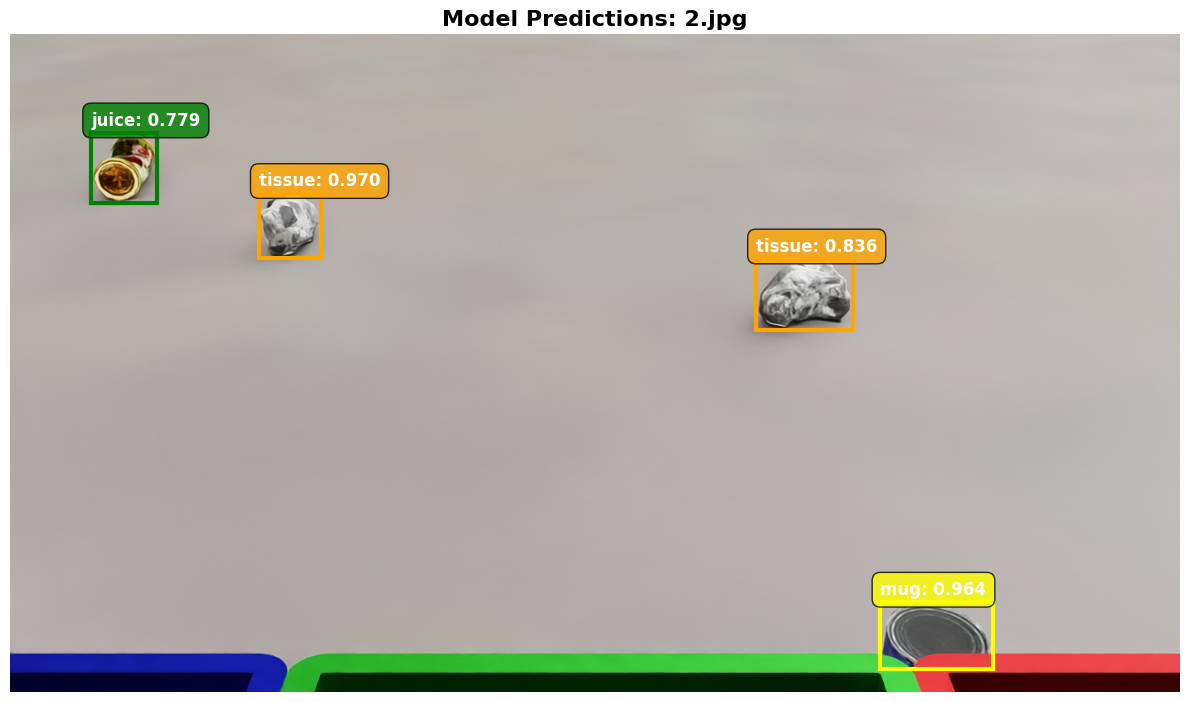

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'wood_block', 1: 'cracker_box', 2: 'juice', 3: 'mug', 4: 'cola_can', 5: 'tissue', 6: 'master_chef_can'}
 obb: None
 orig_img: array([[[168, 173, 176],
         [168, 173, 176],
         [169, 174, 177],
         ...,
         [186, 189, 194],
         [186, 189, 194],
         [186, 189, 194]],
 
        [[169, 174, 177],
         [169, 174, 177],
         [169, 174, 177],
         ...,
         [187, 190, 195],
         [187, 190, 195],
         [187, 190, 195]],
 
        [[169, 174, 177],
         [169, 174, 177],
         [169, 174, 177],
         ...,
         [187, 190, 195],
         [187, 190, 195],
         [187, 190, 195]],
 
        ...,
 
        [[ 42,   2,   3],
         [ 42,   2,   3],
         [ 42,   2,   3],
         ...,
         [  3,   2,  58],
         [  3,   2,  58],
         [  3,   2,  58]],
 
        [[ 42,  

In [4]:
visualize_model_predictions(
    model_path="runs/detect/metasejong_objects_augmented/weights/best.pt",
    image_path="/home/kwdahun/metasejong-YOLO/data/robot_center_camera_example/2.jpg",
    conf_threshold=0.25
)